S(P,D,Q) X AR (p) X I (d) x MA(midium average) (q)
o pdq do S são os lags sazonais


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_excel('SARIMA.xlsx')
df.head()

,Data,y
0,2022-01-01,24.219961
1,2022-01-02,21.483120
2,2022-01-03,21.846712
3,2022-01-04,20.196590
4,2022-01-05,19.661745


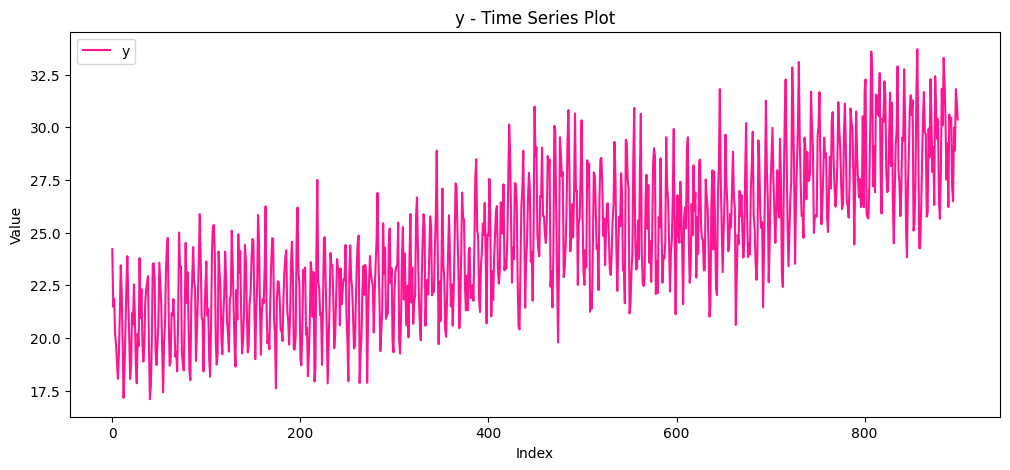

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df['y'], label='y', color="deeppink")
plt.title('y - Time Series Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

ADF Statistic: -0.4635651846059095
p-value: 0.8989325523414318
KPSS Statistic: 5.347532927577247
p-value: 0.01


/tmp/ipython-input-3476733439.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df['y'])


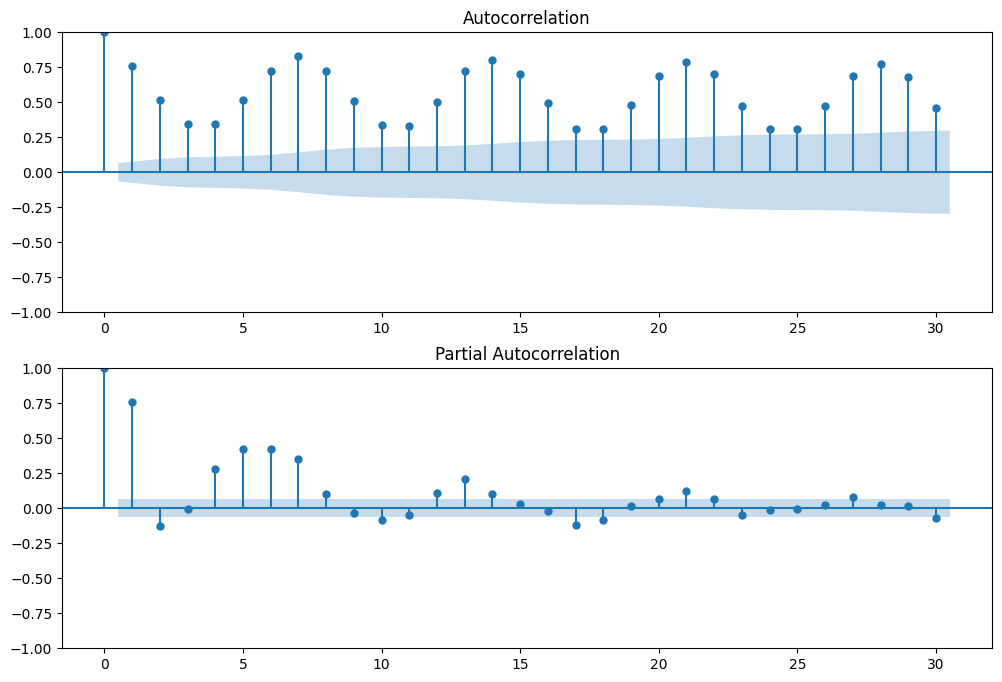

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

adf_test = adfuller(df['y'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

kpss_test = kpss(df['y'])
print(f'KPSS Statistic: {kpss_test[0]}')
print(f'p-value: {kpss_test[1]}')


fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['y'], ax=axes[0])
plot_pacf(df['y'], ax=axes[1])
plt.show()

In [ ]:
df['y_diff'] = df['y'].diff()

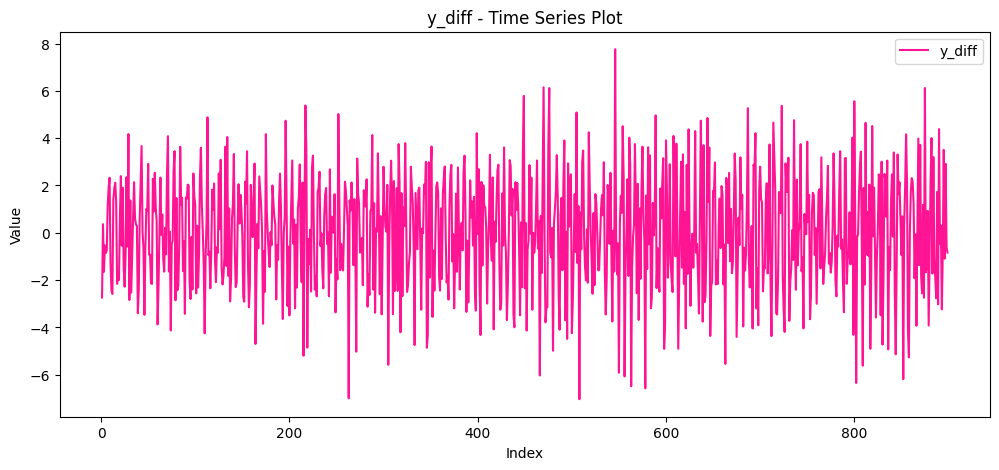

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df['y_diff'], label='y_diff', color="deeppink")
plt.title('y_diff - Time Series Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Teste de estacionariedade na série diferenciada
adf_test_diff = adfuller(df['y_diff'].dropna())
print(f'ADF Statistic (Differenced Series): {adf_test_diff[0]}')
print(f'p-value (Differenced Series): {adf_test_diff[1]}')

ADF Statistic (Differenced Series): -11.621131241661416
p-value (Differenced Series): 2.3830520188602036e-21


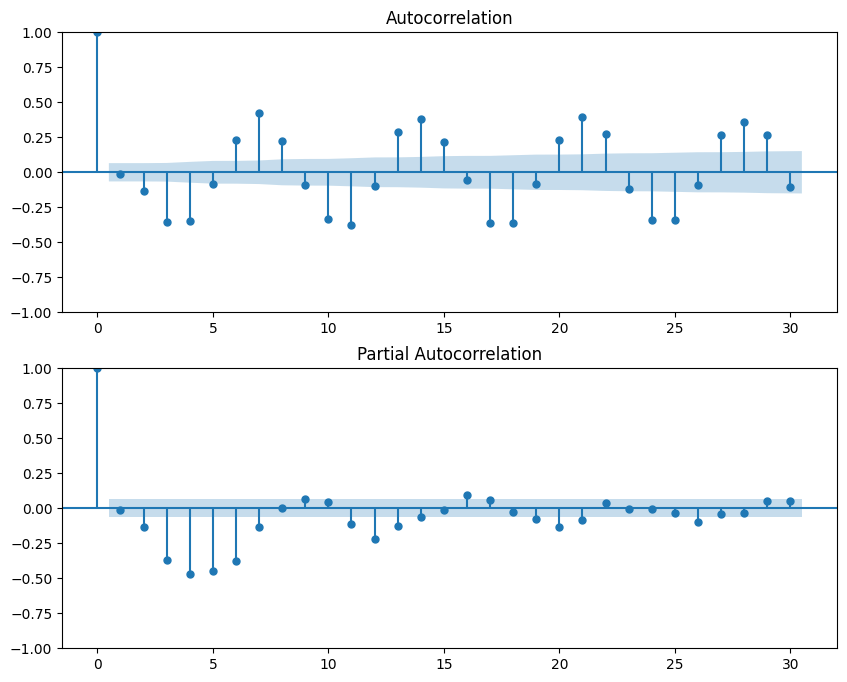

In [ ]:
# ACF e PACF da série diferenciada
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['y_diff'].dropna(), ax=axes[0])
plot_pacf(df['y_diff'].dropna(), ax=axes[1])
plt.show()

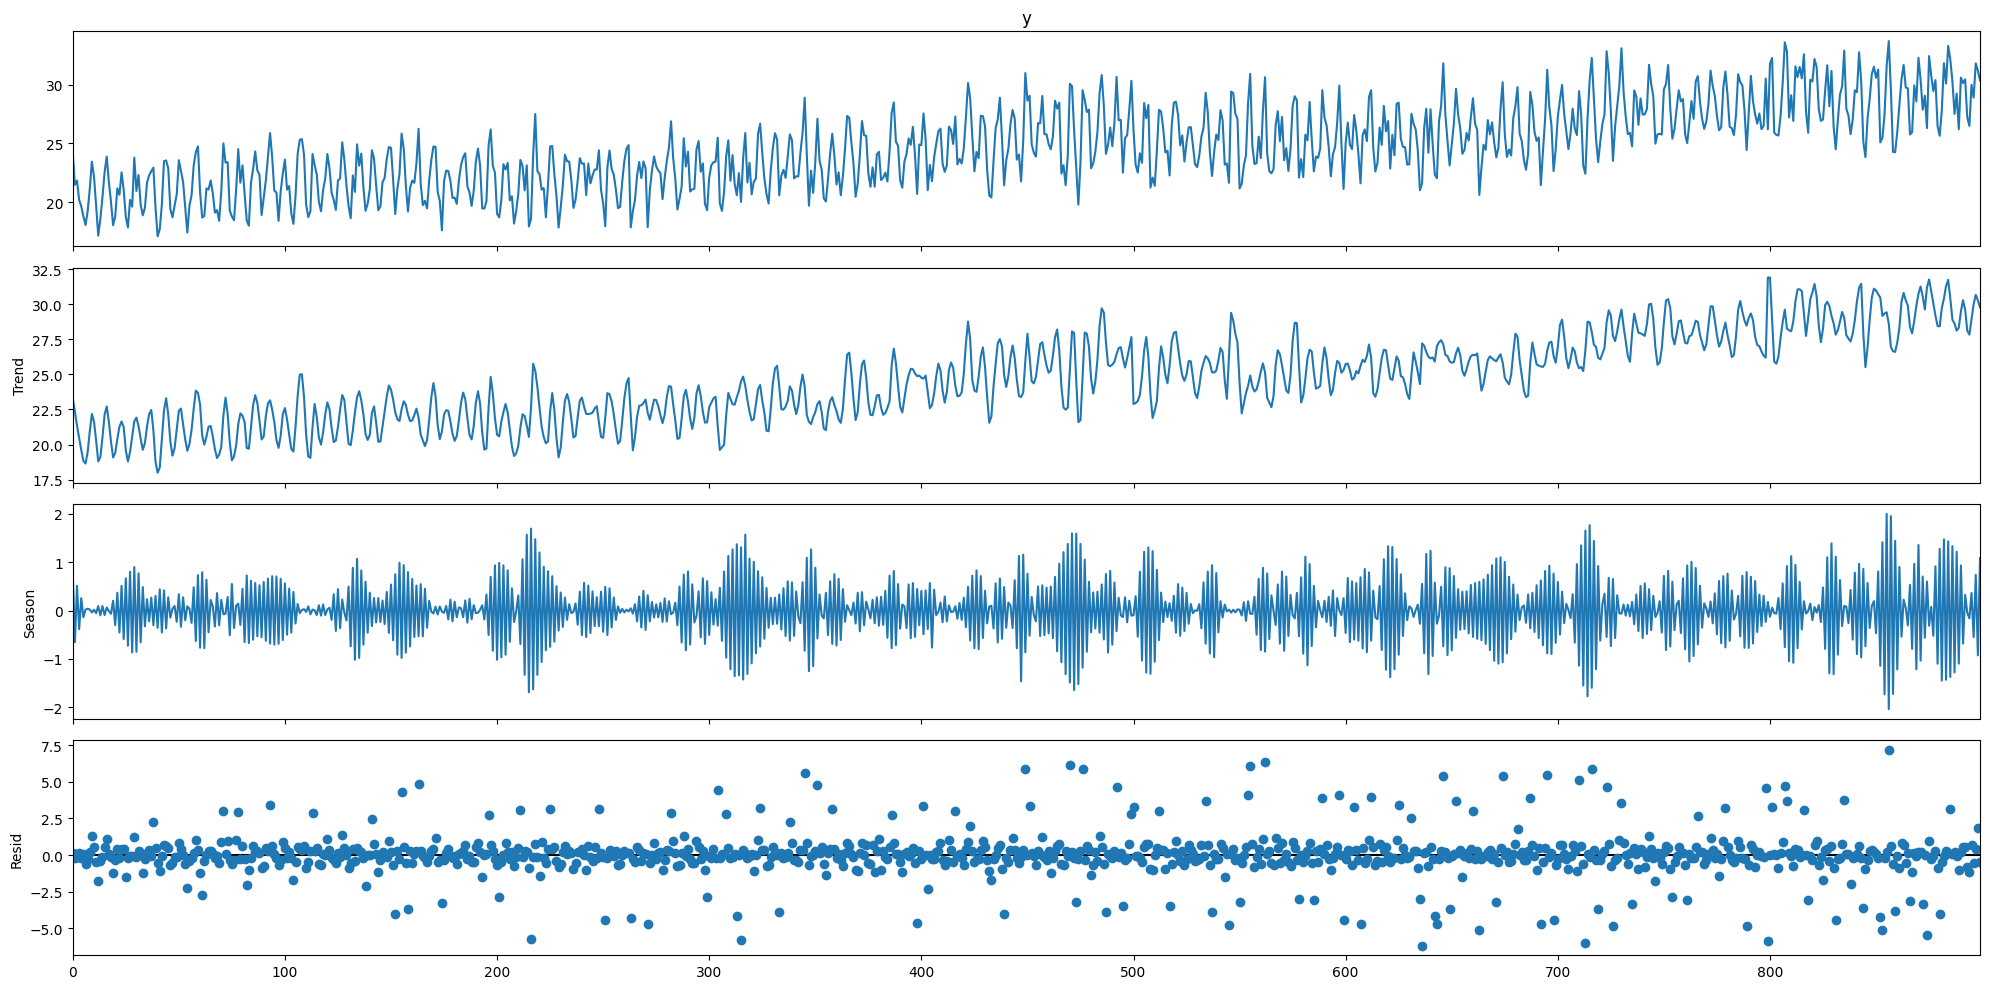

In [ ]:
from statsmodels.tsa.seasonal import STL

m = 2
stl = STL(df['y'], period=m, robust=True).fit()
fig = stl.plot()
fig.set_size_inches(20, 10)
plt.tight_layout()
plt.show()

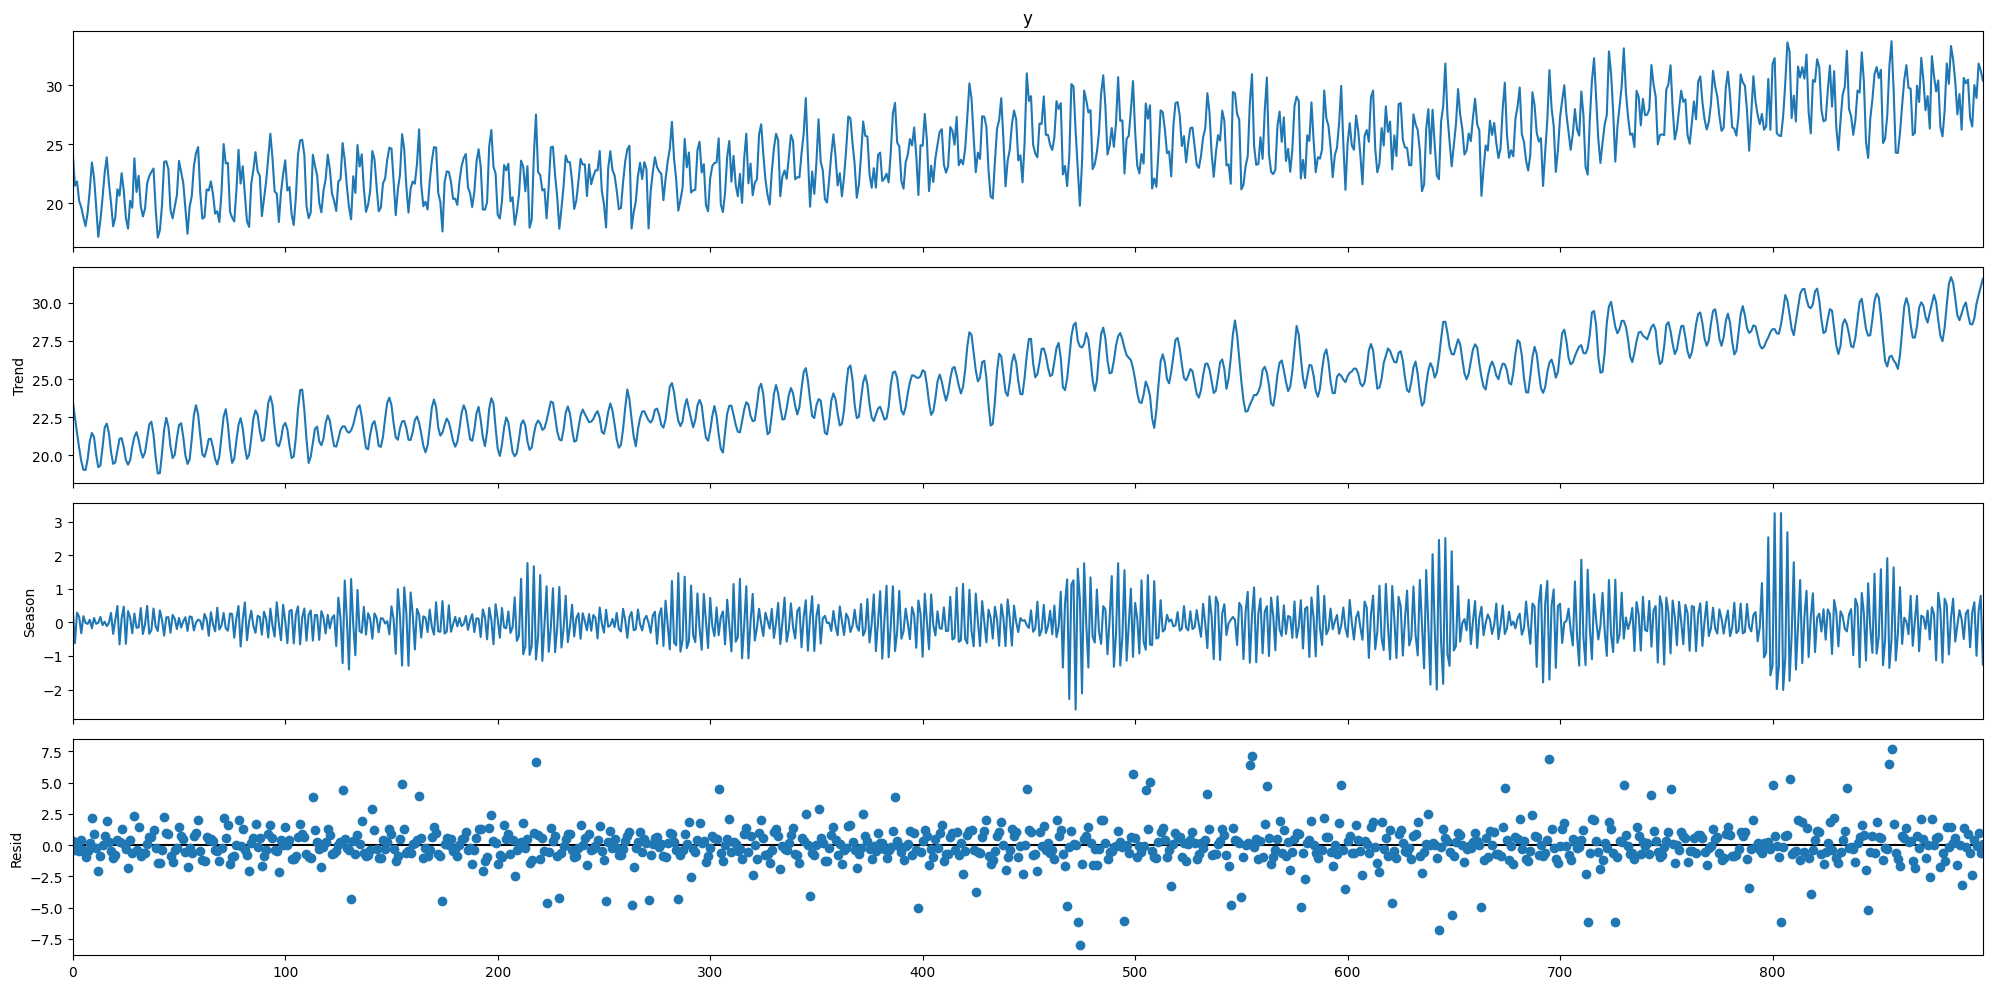

In [ ]:
m = 3
stl = STL(df['y'], period=m, robust=True).fit()
fig = stl.plot()
fig.set_size_inches(20, 10)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
forca_sazonalidade = 1 - (np.var(stl.resid) / np.var(stl.seasonal + stl.resid))
print(f"Força de sazonalidade (0-1): {forca_sazonalidade:.4f}")

Força de sazonalidade (0-1): 0.0195


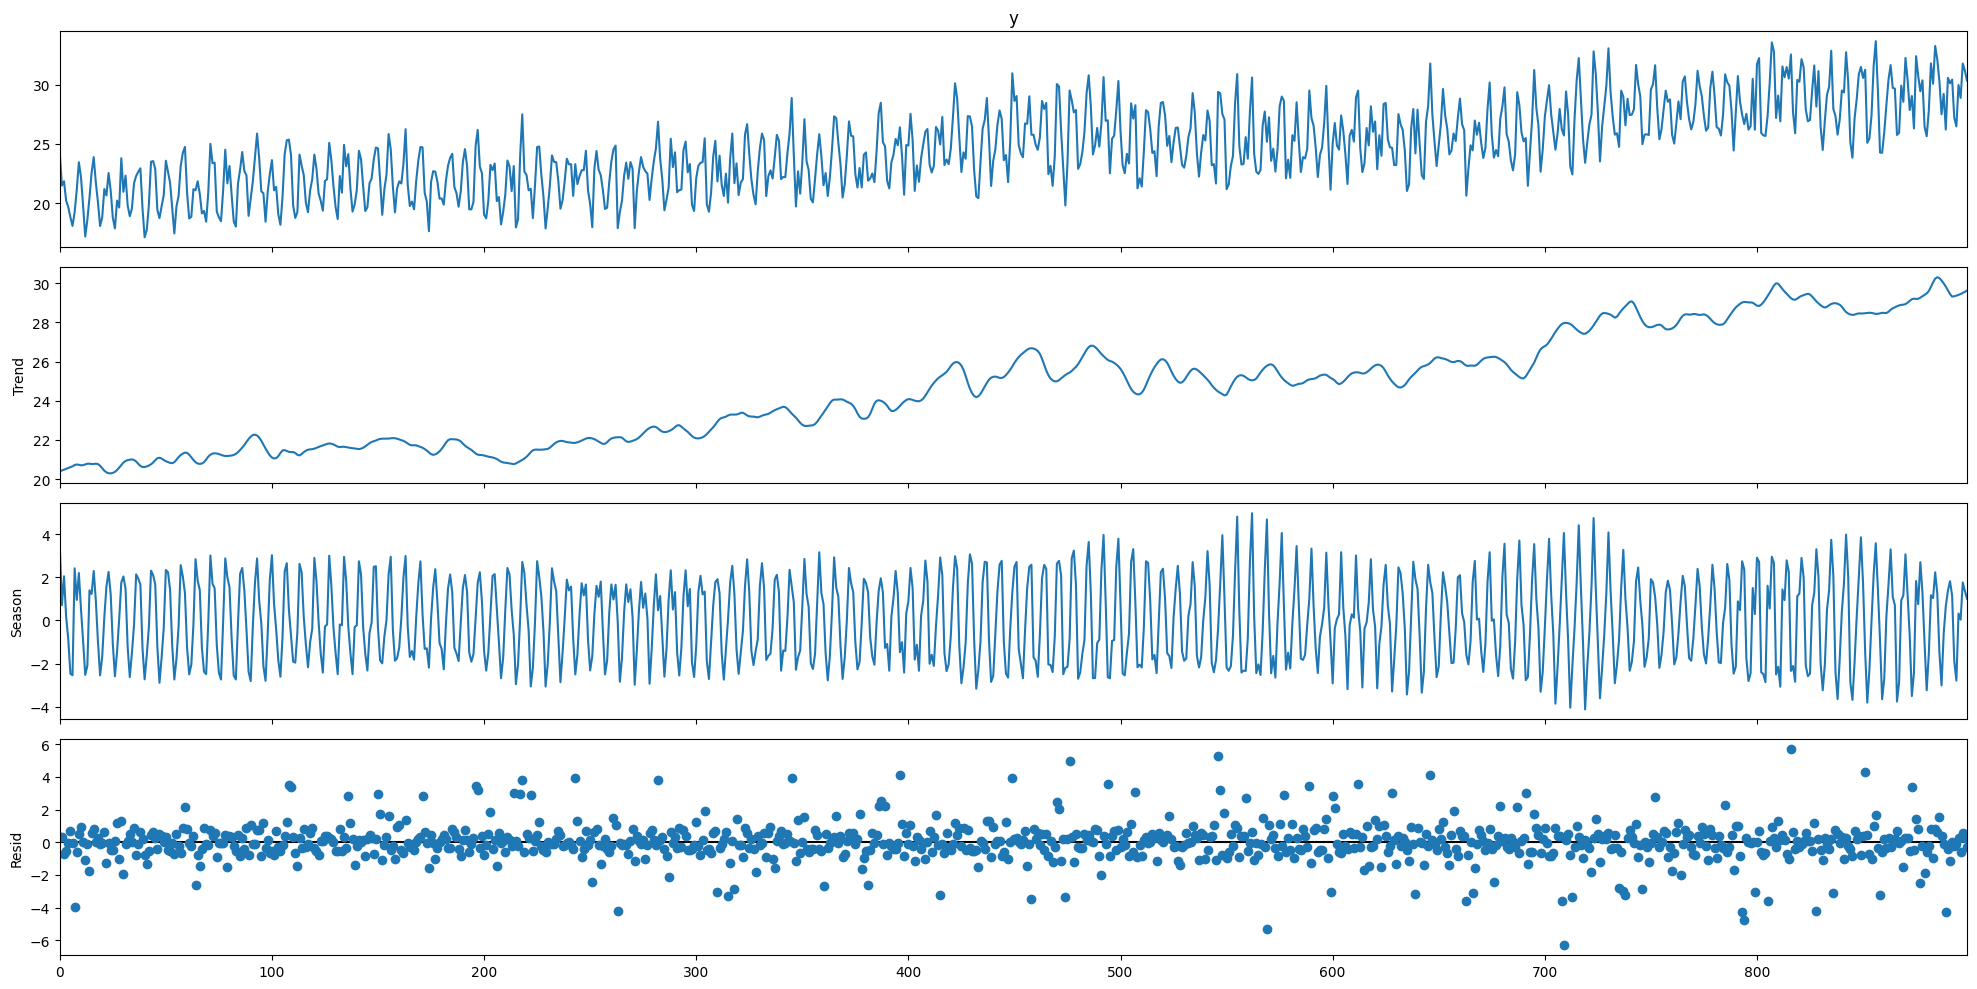

Força de sazonalidade (0-1): 0.7062


In [ ]:
m = 7
stl = STL(df['y'], period=m, robust=True).fit()
fig = stl.plot()
fig.set_size_inches(20, 10)
plt.tight_layout()
plt.show()
forca_sazonalidade = 1 - (np.var(stl.resid) / np.var(stl.seasonal + stl.resid))
print(f"Força de sazonalidade (0-1): {forca_sazonalidade:.4f}")

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

# treino teste
h = 1
ytrain = df['y'].iloc[:-h]
ytest = df['y'].iloc[-h:]

# espaco de busca
m = 7
p_range = [0, 1, 2]
d_range = [0, 1]
q_range = [0, 1, 2]
P_range = [0, 1, 2]
D_range = [0, 1]
Q_range = [0, 1, 2]
def tentar_sarima(order, seasonal_order, y):
    """Tenta ajustar o modelo SARIMA e retorna o resultado se convergir."""
    try:
        model = SARIMAX(
            y,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        res = model.fit(disp=False, maxiter=100)
        return res
    except Exception:
        return None


best_models = []

for p, d, q in product(p_range, d_range, q_range):
    for P, D, Q in product(P_range, D_range, Q_range):
        order = (p, d, q)
        seasonal_order = (P, D, Q, m)
        res = tentar_sarima(order, seasonal_order, ytrain)

        if res:
            print(f"SARIMA{order}{seasonal_order} - AIC: {res.aic:.4f}")
            best_models.append({'aic': res.aic, 'order': order, 'seasonal_order': seasonal_order, 'res': res})
            best_models.sort(key=lambda x: x['aic'])
            best_models = best_models[:5]  # Mantém apenas os 5 melhores

print("\nTop 5 SARIMA Models:")
for i, model_info in enumerate(best_models):
    print(f"{i+1}. Order: {model_info['order']}, Seasonal Order: {model_info['seasonal_order']}, AIC: {model_info['aic']:.4f}")


if best_models:
    best = best_models[0]
    print("\nResumo do Melhor Modelo:")
    print(best['res'].summary())

    # Forecast
    forecast = best['res'].forecast(steps=h)
    print("\nPrevisão:")
    print(forecast)

SARIMA(0, 0, 0)(0, 0, 0, 7) - AIC: 8321.0258
SARIMA(0, 0, 0)(0, 0, 1, 7) - AIC: 7162.6033
SARIMA(0, 0, 0)(0, 0, 2, 7) - AIC: 6336.7039
SARIMA(0, 0, 0)(0, 1, 0, 7) - AIC: 3713.8060
SARIMA(0, 0, 0)(0, 1, 1, 7) - AIC: 3269.7450
SARIMA(0, 0, 0)(0, 1, 2, 7) - AIC: 3250.2161
SARIMA(0, 0, 0)(1, 0, 0, 7) - AIC: 3725.5897
SARIMA(0, 0, 0)(1, 0, 1, 7) - AIC: 3248.7509
SARIMA(0, 0, 0)(1, 0, 2, 7) - AIC: 3228.6691
SARIMA(0, 0, 0)(1, 1, 0, 7) - AIC: 3471.8436
SARIMA(0, 0, 0)(1, 1, 1, 7) - AIC: 3273.2458
SARIMA(0, 0, 0)(1, 1, 2, 7) - AIC: 3252.1045
SARIMA(0, 0, 0)(2, 0, 0, 7) - AIC: 3472.5359
SARIMA(0, 0, 0)(2, 0, 1, 7) - AIC: 3232.3624
SARIMA(0, 0, 0)(2, 0, 2, 7) - AIC: 3227.8309
SARIMA(0, 0, 0)(2, 1, 0, 7) - AIC: 3350.2426
SARIMA(0, 0, 0)(2, 1, 1, 7) - AIC: 3253.0876
SARIMA(0, 0, 0)(2, 1, 2, 7) - AIC: 3249.9332
SARIMA(0, 0, 1)(0, 0, 0, 7) - AIC: 7188.7416
SARIMA(0, 0, 1)(0, 0, 1, 7) - AIC: 6330.6772
SARIMA(0, 0, 1)(0, 0, 2, 7) - AIC: 5749.2663
SARIMA(0, 0, 1)(0, 1, 0, 7) - AIC: 3698.8194
SARIMA(0, 

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 2)(1, 0, 2, 7) - AIC: 3214.4296
SARIMA(0, 0, 2)(1, 1, 0, 7) - AIC: 3464.2869
SARIMA(0, 0, 2)(1, 1, 1, 7) - AIC: 3245.5546
SARIMA(0, 0, 2)(1, 1, 2, 7) - AIC: 3224.0615


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 2)(2, 0, 0, 7) - AIC: 3468.4494


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 2)(2, 0, 1, 7) - AIC: 3213.9752


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(0, 0, 2)(2, 0, 2, 7) - AIC: 3208.1267
SARIMA(0, 0, 2)(2, 1, 0, 7) - AIC: 3342.2527
SARIMA(0, 0, 2)(2, 1, 1, 7) - AIC: 3234.0742
SARIMA(0, 0, 2)(2, 1, 2, 7) - AIC: 3223.7710
SARIMA(0, 1, 0)(0, 0, 0, 7) - AIC: 4124.2900
SARIMA(0, 1, 0)(0, 0, 1, 7) - AIC: 3979.0644
SARIMA(0, 1, 0)(0, 0, 2, 7) - AIC: 3913.0412
SARIMA(0, 1, 0)(0, 1, 0, 7) - AIC: 4213.9484
SARIMA(0, 1, 0)(0, 1, 1, 7) - AIC: 3647.9535
SARIMA(0, 1, 0)(0, 1, 2, 7) - AIC: 3623.5799
SARIMA(0, 1, 0)(1, 0, 0, 7) - AIC: 3924.0719
SARIMA(0, 1, 0)(1, 0, 1, 7) - AIC: 3679.5376
SARIMA(0, 1, 0)(1, 0, 2, 7) - AIC: 3653.0613
SARIMA(0, 1, 0)(1, 1, 0, 7) - AIC: 3979.8211
SARIMA(0, 1, 0)(1, 1, 1, 7) - AIC: 3651.7466
SARIMA(0, 1, 0)(1, 1, 2, 7) - AIC: 3624.2996
SARIMA(0, 1, 0)(2, 0, 0, 7) - AIC: 3842.0492
SARIMA(0, 1, 0)(2, 0, 1, 7) - AIC: 3657.3636
SARIMA(0, 1, 0)(2, 0, 2, 7) - AIC: 3651.7701
SARIMA(0, 1, 0)(2, 1, 0, 7) - AIC: 3847.0748
SARIMA(0, 1, 0)(2, 1, 1, 7) - AIC: 3631.2917
SARIMA(0, 1, 0)(2, 1, 2, 7) - AIC: 3623.2794
SARIMA(0, 

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)(2, 0, 2, 7) - AIC: 3168.5642
SARIMA(2, 0, 2)(2, 1, 0, 7) - AIC: 3339.9796
SARIMA(2, 0, 2)(2, 1, 1, 7) - AIC: 3151.5799


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 0, 2)(2, 1, 2, 7) - AIC: 3143.4918
SARIMA(2, 1, 0)(0, 0, 0, 7) - AIC: 4108.2554
SARIMA(2, 1, 0)(0, 0, 1, 7) - AIC: 3943.0516
SARIMA(2, 1, 0)(0, 0, 2, 7) - AIC: 3846.4993
SARIMA(2, 1, 0)(0, 1, 0, 7) - AIC: 3954.7263
SARIMA(2, 1, 0)(0, 1, 1, 7) - AIC: 3376.8645
SARIMA(2, 1, 0)(0, 1, 2, 7) - AIC: 3356.4241
SARIMA(2, 1, 0)(1, 0, 0, 7) - AIC: 3787.7647
SARIMA(2, 1, 0)(1, 0, 1, 7) - AIC: 3403.7585
SARIMA(2, 1, 0)(1, 0, 2, 7) - AIC: 3383.8704
SARIMA(2, 1, 0)(1, 1, 0, 7) - AIC: 3694.8306
SARIMA(2, 1, 0)(1, 1, 1, 7) - AIC: 3375.3159
SARIMA(2, 1, 0)(1, 1, 2, 7) - AIC: 3354.8471
SARIMA(2, 1, 0)(2, 0, 0, 7) - AIC: 3633.4386
SARIMA(2, 1, 0)(2, 0, 1, 7) - AIC: 3381.2135
SARIMA(2, 1, 0)(2, 0, 2, 7) - AIC: 3377.7756
SARIMA(2, 1, 0)(2, 1, 0, 7) - AIC: 3564.6152
SARIMA(2, 1, 0)(2, 1, 1, 7) - AIC: 3354.4869
SARIMA(2, 1, 0)(2, 1, 2, 7) - AIC: 3353.5283
SARIMA(2, 1, 1)(0, 0, 0, 7) - AIC: 3718.9293
SARIMA(2, 1, 1)(0, 0, 1, 7) - AIC: 3604.9606
SARIMA(2, 1, 1)(0, 0, 2, 7) - AIC: 3533.9891
SARIMA(2, 

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)(2, 1, 2, 7) - AIC: 3139.8450

Top 5 SARIMA Models:
1. Order: (0, 1, 2), Seasonal Order: (1, 1, 2, 7), AIC: 3134.6012
2. Order: (1, 1, 2), Seasonal Order: (1, 1, 2, 7), AIC: 3136.0538
3. Order: (0, 1, 2), Seasonal Order: (2, 1, 2, 7), AIC: 3136.6010
4. Order: (2, 1, 2), Seasonal Order: (1, 1, 2, 7), AIC: 3137.6476
5. Order: (0, 1, 2), Seasonal Order: (0, 1, 2, 7), AIC: 3137.8610

Resumo do Melhor Modelo:
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  899
Model:             SARIMAX(0, 1, 2)x(1, 1, 2, 7)   Log Likelihood               -1561.301
Date:                           Fri, 24 Oct 2025   AIC                           3134.601
Time:                                   10:39:00   BIC                           3163.240
Sample:                                        0   HQIC                          3145.557
                                     

In [ ]:
# Implement the best SARIMA model
best_order = best_models[0]['order']
best_seasonal_order = best_models[0]['seasonal_order']

model = SARIMAX(ytrain, order=best_order, seasonal_order=best_seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False, maxiter=100)

# Make a forecast
forecast = results.forecast(steps=h)

print("\nForecast:")
print(forecast)


Forecast:
899    30.621907
dtype: float64


In [ ]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_backtest(y, order, seas_order, h=7, initial=0.6):
    no = int(len(y) * initial)
    errors = []
    for end in range(no, len(y) - h):
        train = y.iloc[:end]
        try:
            res = SARIMAX(train, order=order, seasonal_order=seas_order,
                          enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=100)
            fc = res.get_forecast(steps=h).predicted_mean.values
            err = np.abs(y.iloc[end:end+h].values - fc)
            errors.append(err)
        except Exception as e:
            print(f"Error during fitting or forecasting: {e}")
            pass
    return np.mean(errors)

In [ ]:
# Example usage of the rolling_backtest function
# Using the best model found in the previous step
mae = rolling_backtest(df['y'], best_order, best_seasonal_order, h=1)
print(f"Mean Absolute Error (MAE) from rolling backtest: {mae:.4f}")